## Evaluation

In [1]:
import json
import torch
import numpy as np
import sys
import os

from tqdm import tqdm

from rdkit import Chem, RDLogger

# Shut up RDKit
logger = RDLogger.logger()
logger.setLevel(RDLogger.CRITICAL)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import Draw

import random


In [2]:
sys.path.append('./SD_LSTM/')
sys.path.append('./LSTM_TF/')
sys.path.append('./VANILLA_VAE/')
sys.path.append('./SD_VAE/')

from sd_vae_sampler import SDVAESampler
from model_sd_vae import SDVAE
from sd_lstm_sampler import SDLSTMSampler
from sd_lstm_utils import load_model as load_sd_lstm_model

from benchmark_vanilla_vae import VanillaVAEHarness

from model_vanilla_vae import VanillaMolVAE
from rnn_utils import load_model

from fast_rnn_sampler import FastSampler
# from rnn_sampler import ConditionalSmilesRnnSampler
from rnn_utils import load_rnn_model


sys.path.append('utils/')

from evaluation_utils import absolute_metrics, amina_metrics, property_metrics, props_from_smiles, plot_smiles, benchmark_reconstruction_QM9

In [3]:
sys.path.append('../utils/')
from property_calculator import PropertyCalculator

pc = PropertyCalculator(['LogP'])

In [4]:
# Clear modules cache
del sys.modules['benchmark_vanilla_vae']

import importlib
importlib.invalidate_caches()
from benchmark_vanilla_vae import VanillaVAEHarness


del sys.modules['evaluation_utils']
import importlib
importlib.invalidate_caches()
from evaluation_utils import absolute_metrics, amina_metrics, property_metrics, props_from_smiles, plot_smiles, benchmark_reconstruction_QM9

### Load Models

In [9]:
!ls ./models/LONG_RUNS/LSTM-ZINC

LSTM_final_0.582.json  LSTM_final_0.582.pt


In [5]:
# Load LSTM Model

lstm_model_path = "models/LSTM_QM9/batch_size_64_2"
lstm_weights_fname = "LSTM_20_1.190.pt"
lstm_definition_fname = "LSTM_20_1.190.json"

'''
lstm_model_path = "models/LSTM_TF_03/"
lstm_weights_fname = 'LSTM_12_1.180.pt'
lstm_definition_fname = 'LSTM_12_1.180.json'
'''

# lstm_model_path = './models/LONG_RUNS/LSTM-ZINC/'
# lstm_weights_fname = 'LSTM_final_0.582.pt'
# lstm_definition_fname = 'LSTM_final_0.582.json'


lstm_sampler = FastSampler(device = 'cpu', batch_size=64)
lstm_model = load_rnn_model(
            model_definition= os.path.join(lstm_model_path, lstm_definition_fname),
            model_weights = os.path.join(lstm_model_path, lstm_weights_fname),
            device = 'cpu',
            )
    
with open(os.path.join(lstm_model_path, lstm_definition_fname)) as pfile:
    model_params = json.load(pfile)

lstm_mpar = model_params['property_names']
print(f'cLSTM Conditioned on Following Props: {lstm_mpar}')

cLSTM Conditioned on Following Props: ['LogP']


In [37]:
'''
lstm_actions, lstm_outputs = self.reg_model.forward(x=None, 
                                                            properties=props,
                                                            hidden = hidden,
                                                            use_teacher_forcing = False, 
                                                            sampling = True,
                                                            return_actions = False, # UGLY: Doesn't matter 
                                                            return_both = True)
'''
properties = torch.Tensor([[-1.1750], [ 0.1395]])


hidden = lstm_model.init_hidden(2, 'cpu')

lstm_model.forward(x=None, properties = properties, hidden = hidden, use_teacher_forcing=False, return_actions=True)

(tensor([[ 9, 41, 19,  9, 19, 19, 19, 25,  9, 24, 19, 41,  9,  2,  2,  2,  2,  2,
           2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
           2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
           2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
           2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
           2,  2,  2,  2,  2,  2,  2,  2,  2],
         [ 8, 31, 17, 29, 17,  8, 31, 10, 31, 19, 19, 19, 31,  2,  2,  2,  2,  2,
           2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2, 17, 34, 17,  8,  8, 34,
           2, 31,  2,  9,  2, 34,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
           2,  2,  2,  2,  2,  2,  2,  2,  2,  2, 17, 34, 17, 31,  2, 17, 19, 34,
          31,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2, 10,
          19, 19, 41,  9,  2,  2,  2,  2,  2]]),
 (tensor([[[ 4.3167e-01, -6.8092e-01,  3.4836e-01,  ..., -8.9244e-03,
             9

In [6]:
# Load Vanilla VAE Model

model_weights = 'models/VANILLA_VAE_QM9_3_Best/SD_LSTM_patient-star-05_Epoch_283_Vl_0.082.pt'
model_definit = 'models/VANILLA_VAE_QM9_3_Best/SD_LSTM_patient-star-05_Epoch_283_Vl_0.082.json'

cvae_sampler = VanillaVAEHarness(batch_size=64, device='cpu')


cvae_model = load_model(model_class=VanillaMolVAE, model_definition=model_definit, model_weights=model_weights, device='cpu')

# ugly hack
cvae_model = cvae_model.to('cpu')
cvae_model.device = 'cpu'
cvae_model.encoder.device = 'cpu'
cvae_model.state_decoder.device = 'cpu'

a Conv1d inited
a Conv1d inited
a Conv1d inited
a Linear inited
a Linear inited
a Linear inited
a Linear inited
a GRU inited
a Linear inited


In [7]:
# Load Regularized Explicit Vanilla VAE Model

file_path = 'ACTION_SAMPLING_VANILLA_VAE/model_vanilla_vae.py'

# Load the module specified by the file path
spec = importlib.util.spec_from_file_location("model_vanilla_vae.py", file_path)
module = importlib.util.module_from_spec(spec)
sys.modules["model_vanilla_vae"] = module
spec.loader.exec_module(module)

explicit_model_class = module.VanillaMolVAE


file_path = 'ACTION_SAMPLING_VANILLA_VAE/action_sampling_vae_sampler.py'

# Load the module specified by the file path
spec = importlib.util.spec_from_file_location("action_sampling_vae_sampler.py", file_path)
module = importlib.util.module_from_spec(spec)
sys.modules["action_sampling_vae_sampler"] = module
spec.loader.exec_module(module)

harness_class = module.VanillaVAEHarness

# model_weights = 'models/ACTION_REGULARIZED_VAE/SD_REG_VANILLA_VAE_square-mouse-81_Epoch_100_Vl_0.250.pt'
# model_definit = 'models/ACTION_REGULARIZED_VAE/SD_REG_VANILLA_VAE_square-mouse-81_Epoch_100_Vl_0.250.json'
model_weights = 'models/ACTION_REGULARIZED_VAE/SD_REG_VANILLA_VAE_sweet-mouse-15_Epoch_339_Vl_0.235.pt'
model_definit = 'models/ACTION_REGULARIZED_VAE/SD_REG_VANILLA_VAE_sweet-mouse-15_Epoch_339_Vl_0.235.json'

reg_exp_cvae_sampler = harness_class(batch_size=64, device='cpu')
reg_exp_cvae_model = load_model(model_class=explicit_model_class, model_definition=model_definit, model_weights=model_weights, device='cpu')


a Conv1d inited
a Conv1d inited
a Conv1d inited
a Linear inited
a Linear inited
a Linear inited
a GRU inited
a Linear inited


In [8]:
# Load Explicit Vanilla VAE Model

# TODO: FIX NAME CLASHES
file_path = 'ACTION_SAMPLING_VANILLA_VAE/model_vanilla_vae.py'

# Load the module specified by the file path
spec = importlib.util.spec_from_file_location("model_vanilla_vae.py", file_path)
module = importlib.util.module_from_spec(spec)
sys.modules["model_vanilla_vae"] = module
spec.loader.exec_module(module)

explicit_model_class = module.VanillaMolVAE

file_path = 'ACTION_SAMPLING_VANILLA_VAE/action_sampling_vae_sampler.py'

# Load the module specified by the file path
spec = importlib.util.spec_from_file_location("action_sampling_vae_sampler.py", file_path)
module = importlib.util.module_from_spec(spec)
sys.modules["action_sampling_vae_sampler"] = module
spec.loader.exec_module(module)

harness_class = module.VanillaVAEHarness

model_weights = 'models/EXPLICIT_VANILLA_VAE_TF_03/SD_LSTM_odd-sunset-14_Epoch_31_Vl_0.351.pt'
model_definit = 'models/EXPLICIT_VANILLA_VAE_TF_03/SD_LSTM_odd-sunset-14_Epoch_31_Vl_0.351.json'

exp_cvae_sampler = harness_class(batch_size=64, device='cpu')

exp_cvae_model = load_model(model_class=explicit_model_class, model_definition=model_definit, model_weights=model_weights, device='cpu')


a Conv1d inited
a Conv1d inited
a Conv1d inited
a Linear inited
a Linear inited
a Linear inited
a GRU inited
a Linear inited


# Dataset

In [7]:
dataset_path = "data/ZINC250K/"
qmds = pd.read_csv(os.path.join(dataset_path, 'ZINC_clean.csv'))
print(qmds.columns)
props = list(qmds.drop(['ZINC_ID', 'SMILES'], axis=1).columns)
print(f'Properties in dataset: {props}')

# Seperate Test Train and Validation Datasets
indecies = np.load('data/ZINC250K/data_splits.npy')

train_smiles = np.array(qmds['SMILES'])[indecies == 0]
val_smiles = np.array(qmds['SMILES'])[indecies == 1]
test_smiles = np.array(qmds['SMILES'])[indecies == 2]

test_props = [ float(a) for a in pd.read_csv('data/ZINC250K/ZINC_clean.csv')['LogP'][indecies == 2]]

FileNotFoundError: [Errno 2] No such file or directory: 'data/QM9/ZINC_clean.csv'

In [8]:
dataset_path = "data/QM9/"
qmds = pd.read_csv(os.path.join(dataset_path, 'QM9_clean.csv'))
print(qmds.columns)
props = list(qmds.drop(['QM9_id', 'SMILES'], axis=1).columns)
print(f'Properties in dataset: {props}')

# Seperate Test Train and Validation Datasets
indecies = np.load('data/QM9/data_splits.npy')

train_smiles = np.array(qmds['SMILES'])[indecies == 0]
val_smiles = np.array(qmds['SMILES'])[indecies == 1]
test_smiles = np.array(qmds['SMILES'])[indecies == 2]

test_props = [ float(a) for a in pd.read_csv('data/QM9/QM9_clean.csv')['LogP'][indecies == 2]]

Index(['QM9_id', 'SMILES', 'LogP'], dtype='object')
Properties in dataset: ['LogP']


In [9]:
print('Longest Sequence Length in QM9:')
print(max([len(a) for a in (list(test_smiles) + list(val_smiles) + list(train_smiles))]) + 2)

Longest Sequence Length in QM9:
36


### Target Property Distributions

In [10]:
prop_names = ['LogP']

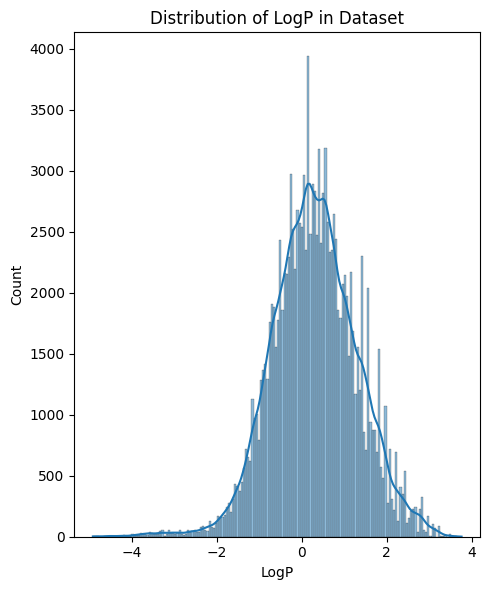

In [11]:
# Distribution of property scores in dataset
plt.figure(figsize=(len(prop_names) * 5, 6))  # Adjust the size as needed

for i, column in enumerate(prop_names):
    plt.subplot(1, len(prop_names), i + 1)  # (1, total number of columns, current column index)
    sns.histplot(qmds[column], kde=True)  # Using seaborn to plot the distribution with a Kernel Density Estimate
    plt.title(f'Distribution of {column} in Dataset')

plt.tight_layout()
plt.show()

# Reconstruction Performance for VAE-based models

In [14]:
from evaluation_utils import amina_metrics, property_metrics, props_from_smiles, plot_smiles, benchmark_reconstruction_QM9

del sys.modules['evaluation_utils']
import importlib
importlib.invalidate_caches()

from evaluation_utils import amina_metrics, property_metrics, props_from_smiles, plot_smiles, benchmark_reconstruction_QM9


In [15]:
benchmark_reconstruction_QM9(cvae_model, cvae_sampler, test_smiles.copy(), test_props.copy())

NameError: name 'cvae_model' is not defined

In [103]:
benchmark_reconstruction_QM9(exp_cvae_model, exp_cvae_sampler, test_smiles.copy(), test_props.copy())

  0%|          | 0/157 [00:00<?, ?it/s]/home/chrome/Code/MolGen/my_code/ACTION_SAMPLING_VANILLA_VAE/model_vanilla_vae.py:313: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).float()
100%|██████████| 157/157 [01:17<00:00,  2.03it/s]

Accuracy: 0.1195
Junk PCT: 0.0


(0.1195, 0.0)

In [15]:
benchmark_reconstruction_QM9(reg_exp_cvae_model, reg_exp_cvae_sampler, test_smiles.copy(), test_props.copy(), random=True)

  0%|          | 0/157 [00:00<?, ?it/s]/home/chrome/Code/MolGen/my_code/ACTION_SAMPLING_VANILLA_VAE/model_vanilla_vae.py:313: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).float()
100%|██████████| 157/157 [01:30<00:00,  1.73it/s]

Accuracy: 0.2746
Junk PCT: 0.0


(0.2746, 0.0)

## Decoder Diversity

In [14]:
n_samples_div = 100
n_runs = 100

In [16]:
model = lstm_model
sampler = lstm_sampler

In [17]:
div_sample_props = []
div_fixed_prop = []

for run in tqdm(range(n_runs)):
    # Sample latent point
    latent_points = torch.tensor(np.random.normal(0, model.eps_std, size=(model.latent_dim)))
    latent_points = latent_points.unsqueeze(0).repeat(n_samples_div, 1)

    # Sample different properties and fixed prop
    sample_props = torch.tensor([[a] for a in random.sample(test_props, n_samples_div)])
    fp = random.sample(test_props, 1)[0]

    fixed_prop = torch.tensor([[fp] for a in range(n_samples_div)])

    # Sample smiles different properties and fixed prop
    smiles_sample = sampler.sample(model, sample_props, random=True, latent_points=latent_points)
    smiles_fixed = sampler.sample(model, fixed_prop, random=True, latent_points=latent_points)
    # Sample single property

    div_sample_props.append( len(set(smiles_sample)) / len(smiles_sample)  )
    div_fixed_prop.append( len(set(smiles_fixed)) / len(smiles_fixed)  )

  0%|          | 0/100 [00:00<?, ?it/s]


AttributeError: 'ConditionalSmilesRnn' object has no attribute 'eps_std'

In [20]:
mean = np.mean(div_sample_props)
std_error = np.std(div_sample_props, ddof=1) / np.sqrt(len(div_sample_props))
print(f'Uniqueness for Fixed Latent Point and Sampled Properties: {mean} +- {std_error}')
mean = np.mean(div_fixed_prop)
std_error = np.std(div_fixed_prop, ddof=1) / np.sqrt(len(div_fixed_prop))
print(f'Uniqueness for Fixed Latent Point and Fixed Property: {mean} +- {std_error}')

Uniqueness for Fixed Latent Point and Sampled Properties: 0.9998 +- 0.0001407052941362898
Uniqueness for Fixed Latent Point and Fixed Property: 0.9974000000000001 +- 0.0006295741706611202


# Compute Performance Metrics

In [18]:
def return_valid_smiles(smiles_list):
    '''
    return smiles list with invalid smiles removed
    '''
    valid = []
    
    for smi in smiles_list:
        try:
            mol = Chem.MolFromSmiles(smi)
            if mol is not None:
                valid.append(smi)
        except:
            pass
    return valid

## Global Sample Uniform Prop Vals

In [19]:
# Load QM9 Test Smiles
'''
n_samples = 10000
property_val_range = [-3, 3]

targets = np.random.uniform(low=property_val_range[0], high=property_val_range[1], size=n_samples)
targets = torch.Tensor([[a] for a in targets])

target_props = [float(a[0]) for a in targets]

'''
target_props = test_props

targets = torch.Tensor( [[a] for a in target_props])
num_to_sample = len(target_props)

In [21]:
max_seq_len = 101

lstm_global_sample_smiles = lstm_sampler.sample(model = lstm_model, properties=targets.clone(), num_to_sample=num_to_sample, max_seq_len=max_seq_len, random_sample=True)
assert(len(lstm_global_sample_smiles) == num_to_sample)

In [73]:
cvae_global_sample_smiles = cvae_sampler.sample(model = cvae_model, properties=targets.clone(), num_to_sample=num_to_sample, max_seq_len=101, random=True)
assert(len(cvae_global_sample_smiles) == num_to_sample)

  0%|          | 0/157 [00:00<?, ?it/s]/home/chrome/Code/MolGen/my_code/./VANILLA_VAE/model_vanilla_vae.py:273: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).float()
100%|██████████| 157/157 [00:59<00:00,  2.65it/s]


In [77]:
exp_cvae_global_sample_smiles = exp_cvae_sampler.sample(model = exp_cvae_model, properties=targets.clone(), num_to_sample=num_to_sample, max_seq_len=101, random=True)
assert(len(exp_cvae_global_sample_smiles) == num_to_sample)

100%|██████████| 157/157 [01:16<00:00,  2.06it/s]


In [19]:
reg_exp_cvae_global_sample_smiles = reg_exp_cvae_sampler.sample(model = reg_exp_cvae_model, properties=targets.clone(), num_to_sample=num_to_sample, max_seq_len=101, random=False)
assert(len(reg_exp_cvae_global_sample_smiles) == num_to_sample)

100%|██████████| 157/157 [01:32<00:00,  1.71it/s]


In [22]:
lstm_global_properties = props_from_smiles(lstm_global_sample_smiles)
# cvae_global_properties = props_from_smiles(cvae_global_sample_smiles)
# exp_cvae_global_properties = props_from_smiles(exp_cvae_global_sample_smiles)
# reg_exp_cvae_global_properties = props_from_smiles(reg_exp_cvae_global_sample_smiles)

100%|██████████| 10000/10000 [00:02<00:00, 3626.41it/s]


NameError: name 'cvae_global_properties' is not defined

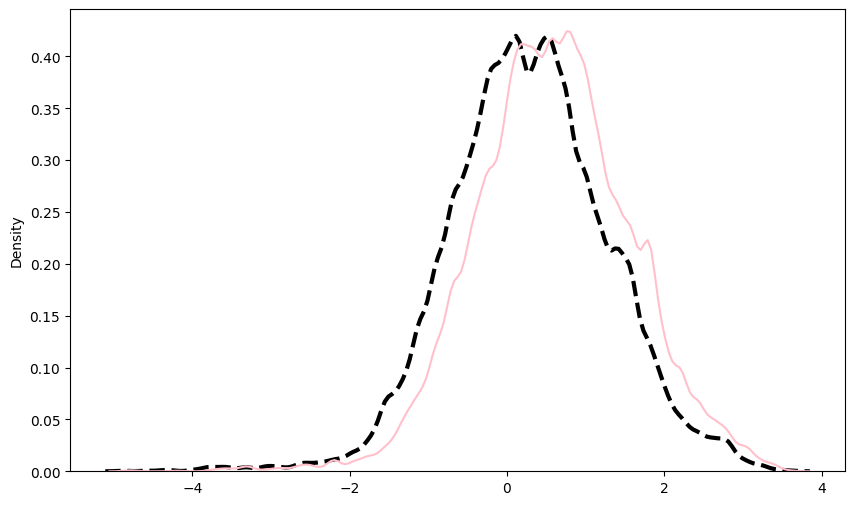

In [24]:
plt.figure(figsize=(10, 6))

sns.kdeplot(target_props, color="black", label='Target Prop Sample', bw_adjust=0.5, linestyle="--", linewidth=3 )
sns.kdeplot(lstm_global_properties, color = "pink", label='LSTM', bw_adjust=0.5)
sns.kdeplot(cvae_global_properties, color = "red", label='cVAE', bw_adjust=0.5)
sns.kdeplot(exp_cvae_global_properties, color = "brown", label='Exp-cVAE', bw_adjust=0.5)
sns.kdeplot(reg_exp_cvae_global_properties, color = "purple", label='Reg-Exp-cVAE-', bw_adjust=0.5, linewidth=3)
# pval0 = property_val_range[0]
# pval1 = property_val_range[1]

plt.title(f'Distribution of property scores for test set property targets')# {pval0} : {pval1})')
plt.legend()
plt.show()

## Sample Metrics
Validity, uniqeness, novelty

In [25]:
lstm_metrics = amina_metrics(lstm_global_sample_smiles, train_smiles.copy())
# cvae_metrics = amina_metrics(cvae_global_sample_smiles, train_smiles.copy())
# exp_cvae_metrics = amina_metrics(exp_cvae_global_sample_smiles, train_smiles.copy())
# reg_exp_cvae_metrics = amina_metrics(reg_exp_cvae_global_sample_smiles, train_smiles.copy())


In [26]:
lstm_metrics

(0.9883, 0.9518364868966913, 0.21728500053151908)

In [92]:
abs_lstm_metrics = absolute_metrics(lstm_global_sample_smiles, train_smiles.copy())
abs_cvae_metrics = absolute_metrics(cvae_global_sample_smiles, train_smiles.copy())
abs_exp_cvae_metrics = absolute_metrics(exp_cvae_global_sample_smiles, train_smiles.copy())
abs_reg_exp_cvae_metrics = absolute_metrics(reg_exp_cvae_global_sample_smiles, train_smiles.copy())

In [96]:
abs_reg_exp_cvae_metrics

(0.8433, 0.8175, 0.3628)

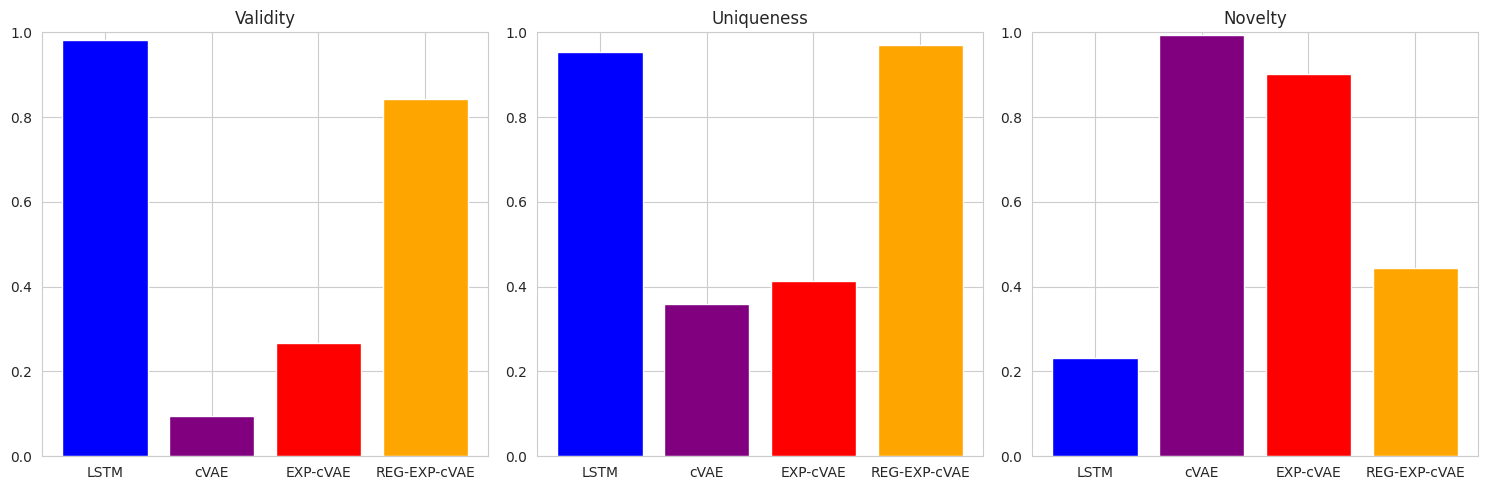

In [118]:
models = ['LSTM', 'cVAE', 'EXP-cVAE', 'REG-EXP-cVAE']
metrics = ['Validity', 'Uniqueness', 'Novelty']
data = {
    'Validity': [lstm_metrics[0], cvae_metrics[0], exp_cvae_metrics[0], reg_exp_cvae_metrics[0]],
    'Uniqueness': [lstm_metrics[1], cvae_metrics[1], exp_cvae_metrics[1], reg_exp_cvae_metrics[1]],
    'Novelty': [lstm_metrics[2], cvae_metrics[2], exp_cvae_metrics[2], reg_exp_cvae_metrics[2]]
}

# Plotting
fig, axes = plt.subplots(1, len(metrics), figsize=(15, 5))

for ax, metric in zip(axes, metrics):
    ax.bar(models, data[metric], color=['blue', 'purple', 'red', 'orange'])
    ax.set_title(metric)
    ax.set_ylim(0, 1)  # Adjust based on your metric score range

plt.tight_layout()
plt.show()

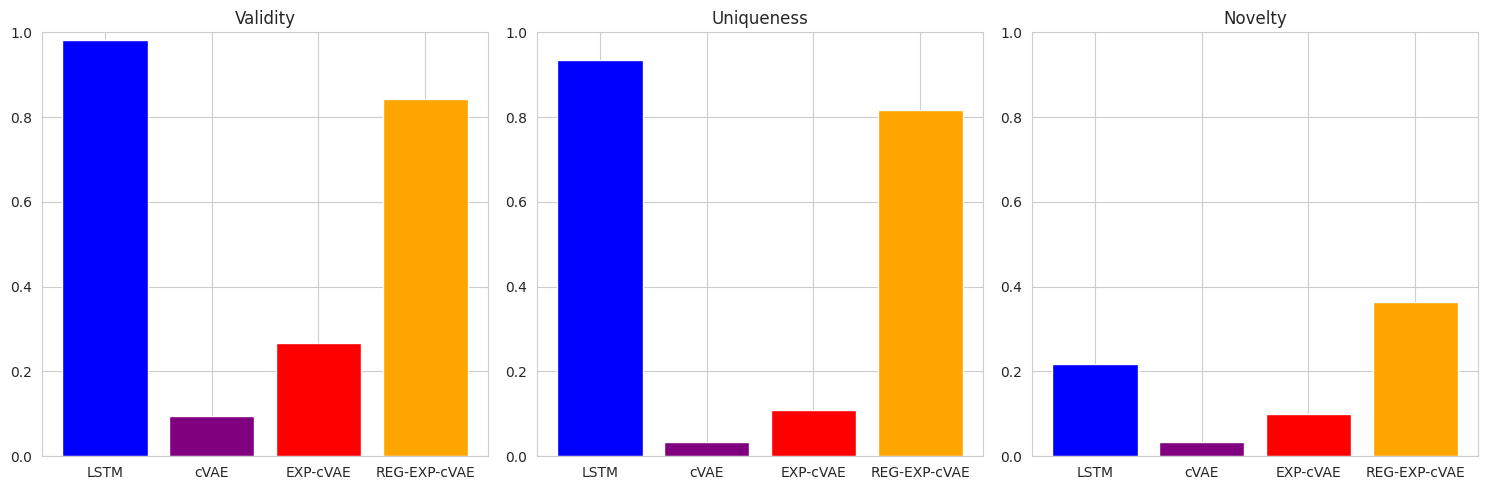

In [119]:
models = ['LSTM', 'cVAE', 'EXP-cVAE', 'REG-EXP-cVAE']
metrics = ['Validity', 'Uniqueness', 'Novelty']
data = {
    'Validity': [abs_lstm_metrics[0], abs_cvae_metrics[0], abs_exp_cvae_metrics[0], abs_reg_exp_cvae_metrics[0]],
    'Uniqueness': [abs_lstm_metrics[1], abs_cvae_metrics[1], abs_exp_cvae_metrics[1], abs_reg_exp_cvae_metrics[1]],
    'Novelty': [abs_lstm_metrics[2], abs_cvae_metrics[2], abs_exp_cvae_metrics[2], abs_reg_exp_cvae_metrics[2]]
}

# Plotting
fig, axes = plt.subplots(1, len(metrics), figsize=(15, 5))

for ax, metric in zip(axes, metrics):
    ax.bar(models, data[metric], color=['blue', 'purple', 'red', 'orange'])
    ax.set_title(metric)
    ax.set_ylim(0, 1)  # Adjust based on your metric score range

plt.tight_layout()
plt.show()

## Property Metrics

In [25]:
lstm_p_metrics = property_metrics(lstm_global_sample_smiles.copy(), targets.clone(), prop_names = ['LogP'])
# cvae_p_metrics = property_metrics(cvae_global_sample_smiles.copy(), targets.clone(), prop_names = ['LogP'])
# exp_cvae_p_metrics = property_metrics(exp_cvae_global_sample_smiles.copy(), targets.clone(), prop_names = ['LogP'])
# reg_exp_cvae_p_metrics = property_metrics(reg_exp_cvae_global_sample_smiles.copy(), targets.clone(), prop_names = ['LogP'])

In [26]:
lstm_p_metrics

([0.9514398208902962], [tensor(3.1432)])

/tmp/ipykernel_7753/4245522979.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax, x=list(values.keys()), y=list(values.values()), palette='viridis')
/tmp/ipykernel_7753/4245522979.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax, x=list(values.keys()), y=list(values.values()), palette='viridis')


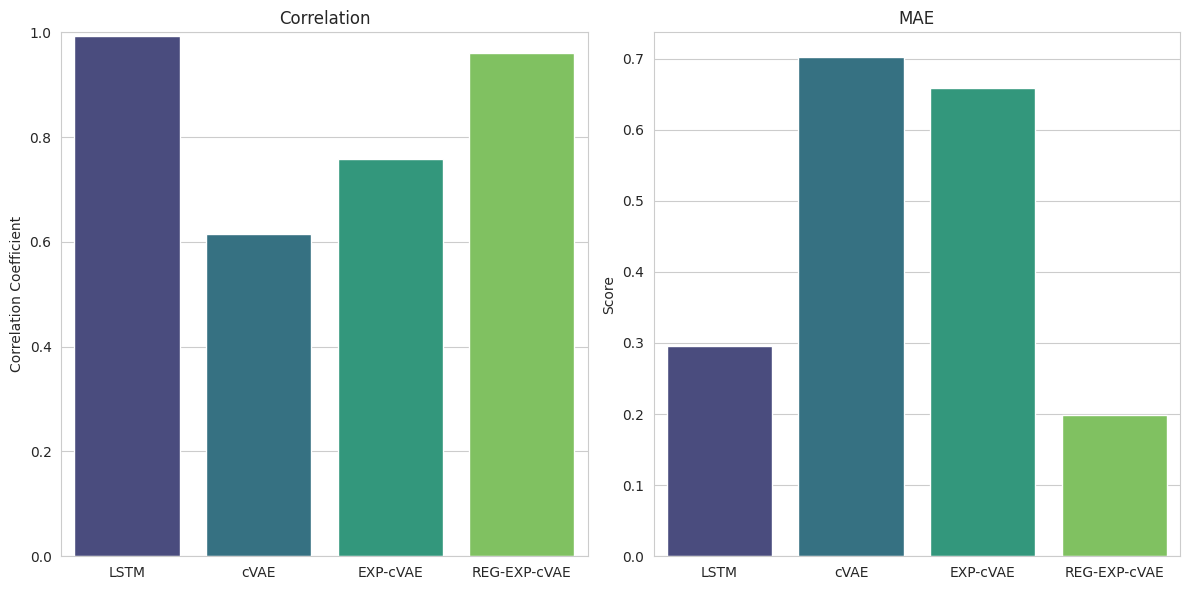

In [115]:
models = ['LSTM', 'SD-LSTM', 'VAE', 'SD-VAE']
metrics_data = {
    'Correlation': {
        'LSTM': lstm_p_metrics[0][0],
        'cVAE': cvae_p_metrics[0][0],
        'EXP-cVAE': exp_cvae_p_metrics[0][0],
        'REG-EXP-cVAE': reg_exp_cvae_p_metrics[0][0]
    },
    'MAE': {
        'LSTM': float(lstm_p_metrics[1][0]),
        'cVAE': float(cvae_p_metrics[1][0]),
        'EXP-cVAE': float(exp_cvae_p_metrics[1][0]),
        'REG-EXP-cVAE': float(reg_exp_cvae_p_metrics[1][0])
    }
}

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.set_style("whitegrid")

for ax, (metric, values) in zip(axes, metrics_data.items()):
    sns.barplot(ax=ax, x=list(values.keys()), y=list(values.values()), palette='viridis')
    ax.set_title(metric)
    ax.set_ylabel('Score' if metric == 'MAE' else 'Correlation Coefficient')
    ax.set_ylim(0, 1 if metric == 'Correlation' else None)  # Adjust the y-axis limit for correlation

plt.tight_layout()
plt.show()

## Visualise sample of smiles

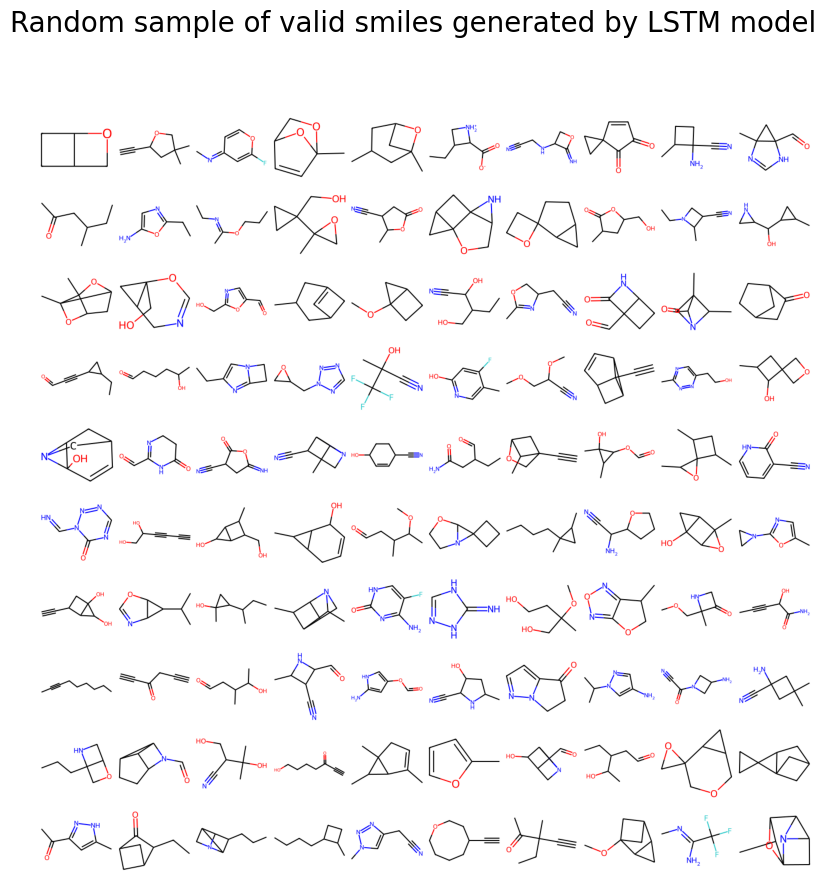

In [28]:
plot_smiles(lstm_global_sample_smiles, title="Random sample of valid smiles generated by LSTM model")

# Performance as a Funct. of Target Value

In [121]:
property_steps = np.arange(-3, 3, 0.5)
samp_per_step = 500

In [37]:
model_sampler = explicit_vae_sampler
model_model = explicit_vae_model

In [39]:
# Now for sd_lstm
model_pstep_smiles = {
    'validity': [],
    'unique_pct': [],
    'novelty':[]
    }

model_steps_properties = []
model_steps_stats = {
    'Failed to decode':[],
    'Invalid Smiles':[],
    'Valid': []
}

model_steps_properties = []

for p_val in tqdm(property_steps):
    props = torch.Tensor([[p_val] for i in range(samp_per_step)])
    smiles = model_sampler.sample(model=model_model, properties=torch.Tensor(props), num_to_sample = samp_per_step, max_seq_len=101)
    missing = samp_per_step - len(smiles)
    valid_smiles = return_valid_smiles(smiles)
    invalid = (samp_per_step - missing) - len(valid_smiles)
    properties = props_from_smiles(valid_smiles)

    try:
        valid, uniq, novel = amina_metrics(smiles, props)
    except ZeroDivisionError:
        valid = 0.0
        uniq = 0.0
        novel = 0.0

    model_pstep_smiles['validity'].append(valid)
    model_pstep_smiles['unique_pct'].append(uniq)
    model_pstep_smiles['novelty'].append(novel)
    

    model_steps_properties.append(properties)
    model_steps_stats['Failed to decode'].append(missing)
    model_steps_stats['Invalid Smiles'].append(invalid)
    model_steps_stats['Valid'].append(samp_per_step - missing - invalid)



  0%|          | 0/12 [00:00<?, ?it/s]/home/chrome/Code/MolGen/my_code/ACTION_SAMPLING_VANILLA_VAE/model_vanilla_vae.py:313: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).float()
100%|██████████| 12/12 [00:53<00:00,  4.48s/it]


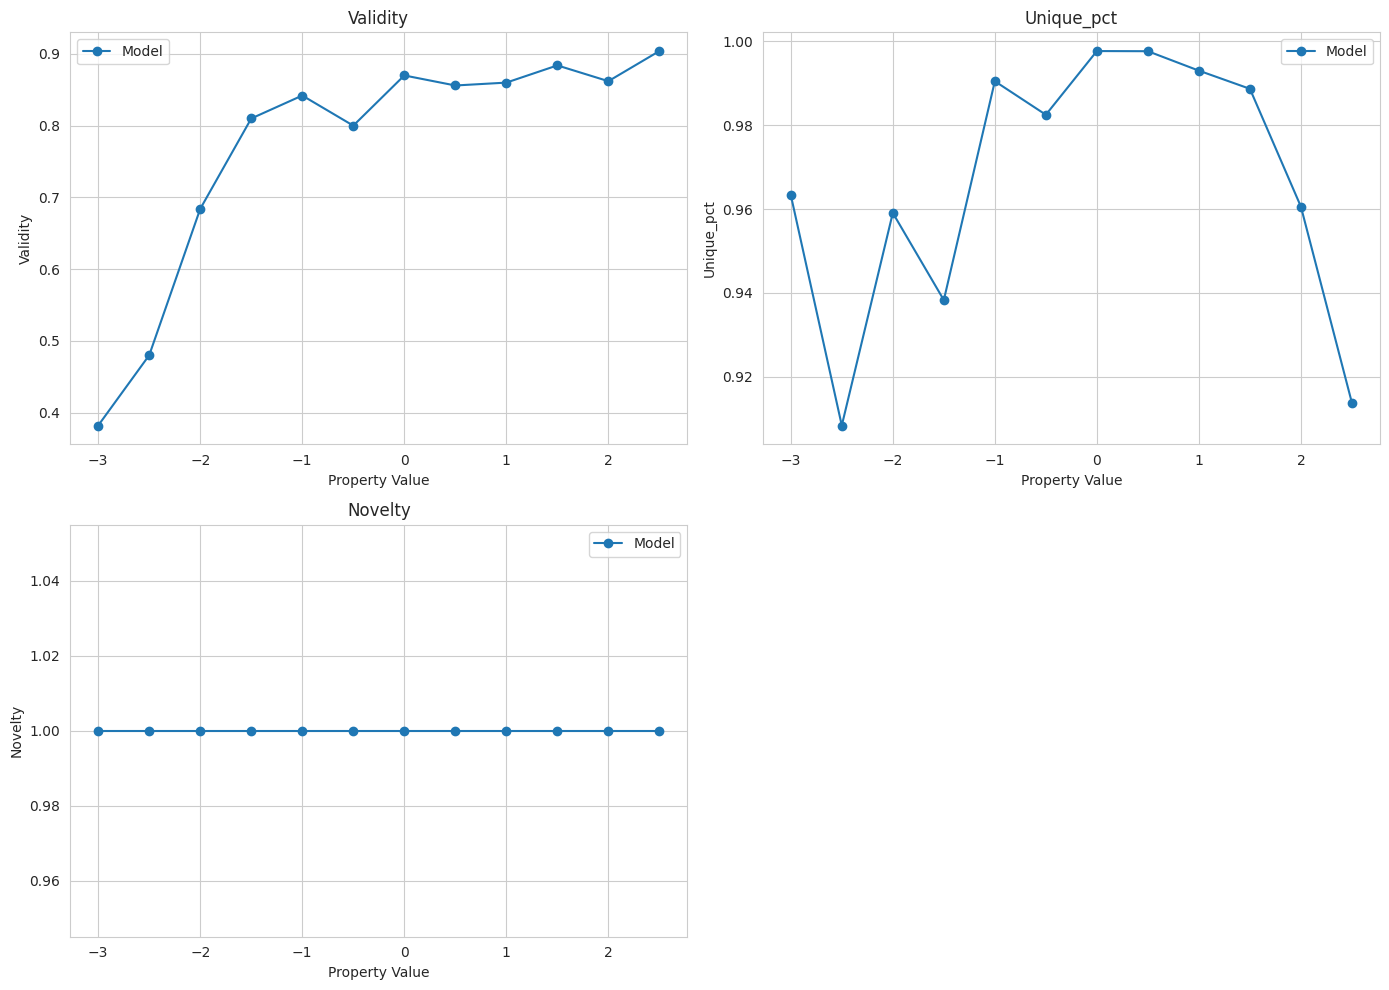

In [40]:
# Assume we have properties for both models in sd_lstm_pstep_smiles and lstm_pstep_smiles
keys = ['validity', 'unique_pct', 'novelty']

plt.figure(figsize=(14, 10))

for i, key in enumerate(keys, 1):
    plt.subplot(2, 2, i)
    plt.plot(property_steps, model_pstep_smiles[key], label='Model', marker='o', linestyle='-')

    plt.title(key.capitalize())
    plt.xlabel('Property Value')
    plt.ylabel(key.capitalize())
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

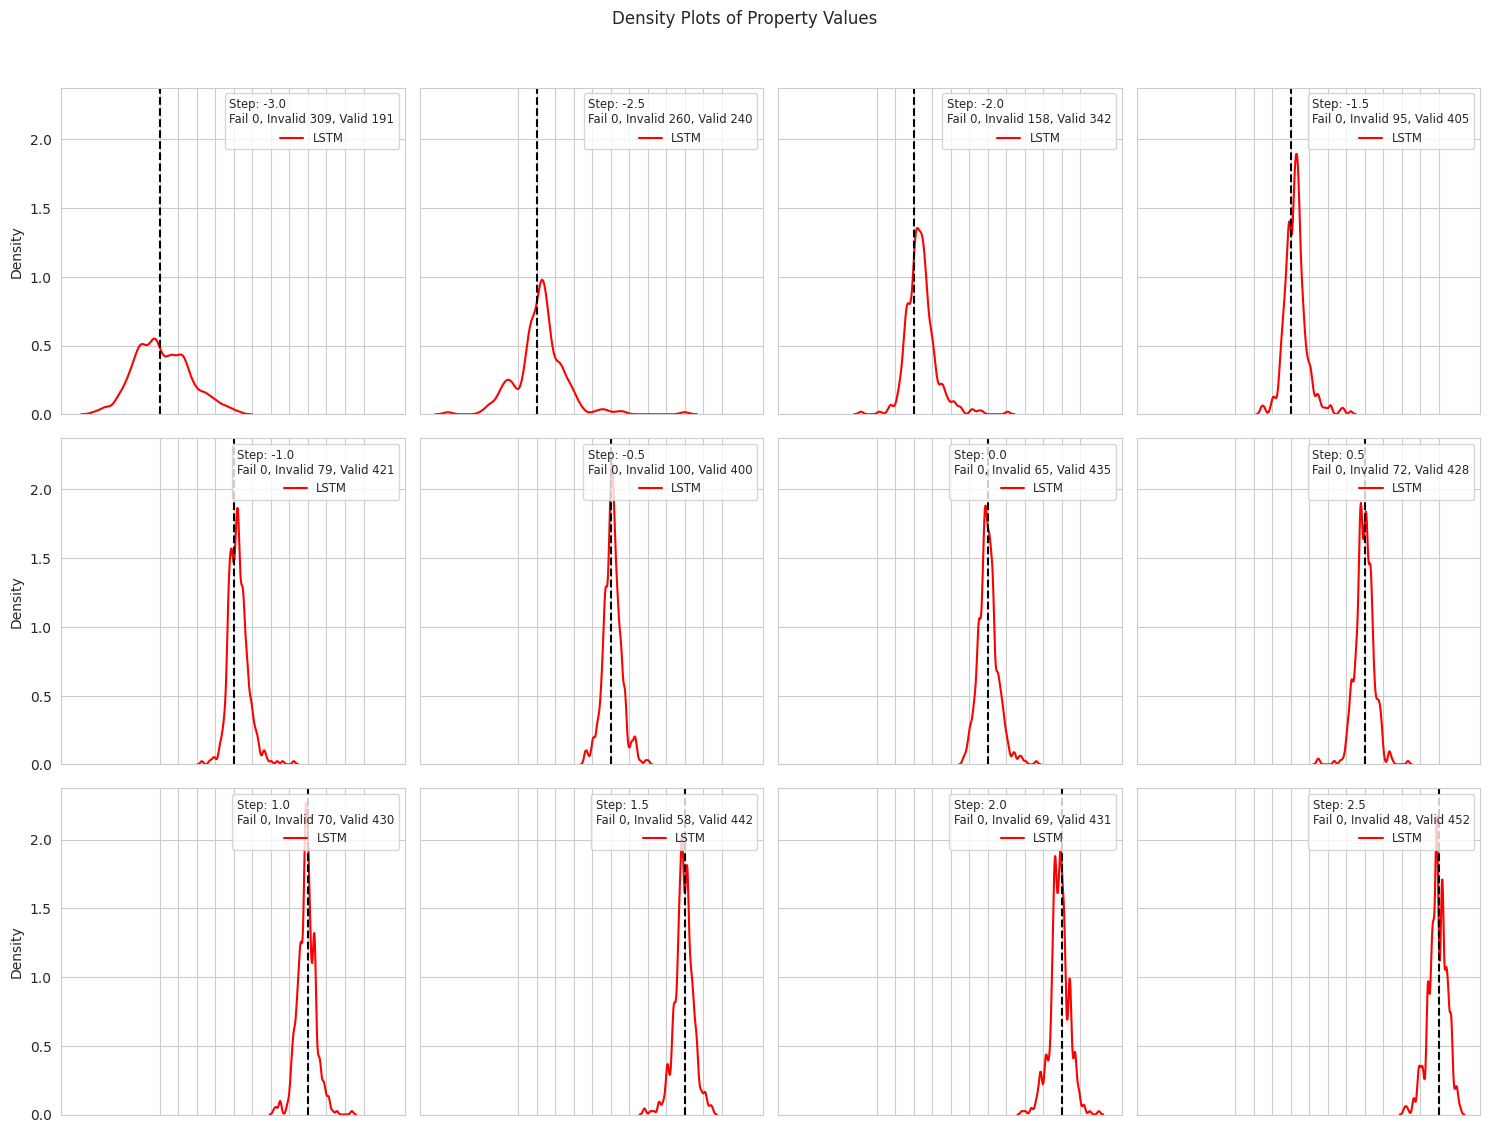

In [41]:

# Create a 4x4 grid of subplots
fig, axes = plt.subplots(4, 4, figsize=(15, 15), sharex=True, sharey=True)
fig.suptitle('Density Plots of Property Values')

# Flatten the axes for easy iteration
axes_flat = axes.flatten()

# Loop through each property step and create the corresponding plot
for i, p_val in enumerate(property_steps):
    ax = axes_flat[i]
    
    if model_steps_properties[i]:
        sns.kdeplot(model_steps_properties[i], ax=ax, color='red', label='LSTM', bw_adjust=0.5)

    # Vertical line for the target property value
    ax.axvline(x=p_val, color='black', linestyle='--')

    ax.set_xticks(property_steps)

    # Adding legend with dynamic title
    ax.legend(title=f'Step: {p_val}\nFail {model_steps_stats["Failed to decode"][i]}, Invalid {model_steps_stats["Invalid Smiles"][i]}, Valid {model_steps_stats["Valid"][i]}',
              loc='upper right', fontsize='small', title_fontsize='small')

    # Setting labels for each subplot
    ax.set_xlabel('Property Value')
    ax.set_ylabel('Density')

# Hide any unused subplots
for j in range(i + 1, 16):
    fig.delaxes(axes_flat[j])

# Adjust layout to avoid overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the suptitle

# Show the plot
plt.show()

In [125]:
property_steps = np.arange(-3, 3, 0.5)
samp_per_step = 500

model_steps_properties = {
                        'LSTM':[],
                        'cVAE':[],
                        'EXP-cVAE':[],
                        'REG-EXP-cVAE':[],
                        }


for p_val in tqdm(property_steps):
    props = torch.Tensor([[p_val] for i in range(samp_per_step)])
    smiles = lstm_sampler.sample(model=lstm_model, properties=torch.Tensor(props).clone(), num_to_sample = samp_per_step, max_seq_len=101, random_sample=True)
    model_steps_properties['LSTM'].append(props_from_smiles(smiles))

    smiles = cvae_sampler.sample(model=cvae_model, properties=torch.Tensor(props).clone(), num_to_sample = samp_per_step, max_seq_len=101, random=True)
    model_steps_properties['cVAE'].append(props_from_smiles(smiles))

    smiles = exp_cvae_sampler.sample(model=exp_cvae_model, properties=torch.Tensor(props).clone(), num_to_sample = samp_per_step, max_seq_len=101, random=True)
    model_steps_properties['EXP-cVAE'].append(props_from_smiles(smiles))

    smiles = reg_exp_cvae_sampler.sample(model=reg_exp_cvae_model, properties=torch.Tensor(props).clone(), num_to_sample = samp_per_step, max_seq_len=101, random=True)
    model_steps_properties['REG-EXP-cVAE'].append(props_from_smiles(smiles))



100%|██████████| 12/12 [03:25<00:00, 17.11s/it]


In [126]:
model_steps_properties

{'LSTM': [[-1.9971999999999985,
   -3.126599999999999,
   -3.024799999999999,
   -3.121199999999999,
   -3.430399999999999,
   -2.5394999999999985,
   -2.5378999999999987,
   -2.6819999999999986,
   -2.882299999999999,
   -3.1785999999999985,
   -2.1093999999999973,
   -2.5378999999999987,
   -2.0299999999999985,
   -2.4919199999999995,
   -2.680399999999999,
   -1.4600999999999986,
   -2.1068000000000002,
   -1.3164199999999993,
   -1.4725999999999997,
   -2.2122600000000006,
   -2.2902999999999984,
   -2.8822999999999985,
   -2.5394999999999985,
   -3.339999999999998,
   -2.9766999999999983,
   -2.9766999999999983,
   -2.9113999999999978,
   -2.9776999999999987,
   -3.0257999999999985,
   -2.6819999999999986,
   -3.0067999999999993,
   -2.7912000000000003,
   -2.2829200000000003,
   -2.6059999999999994,
   -3.301499999999998,
   -2.8229,
   -3.61752,
   -3.121199999999999,
   -2.243199999999999,
   -1.729309999999999,
   -2.924599999999999,
   -1.9671999999999996,
   -2.8341999999999

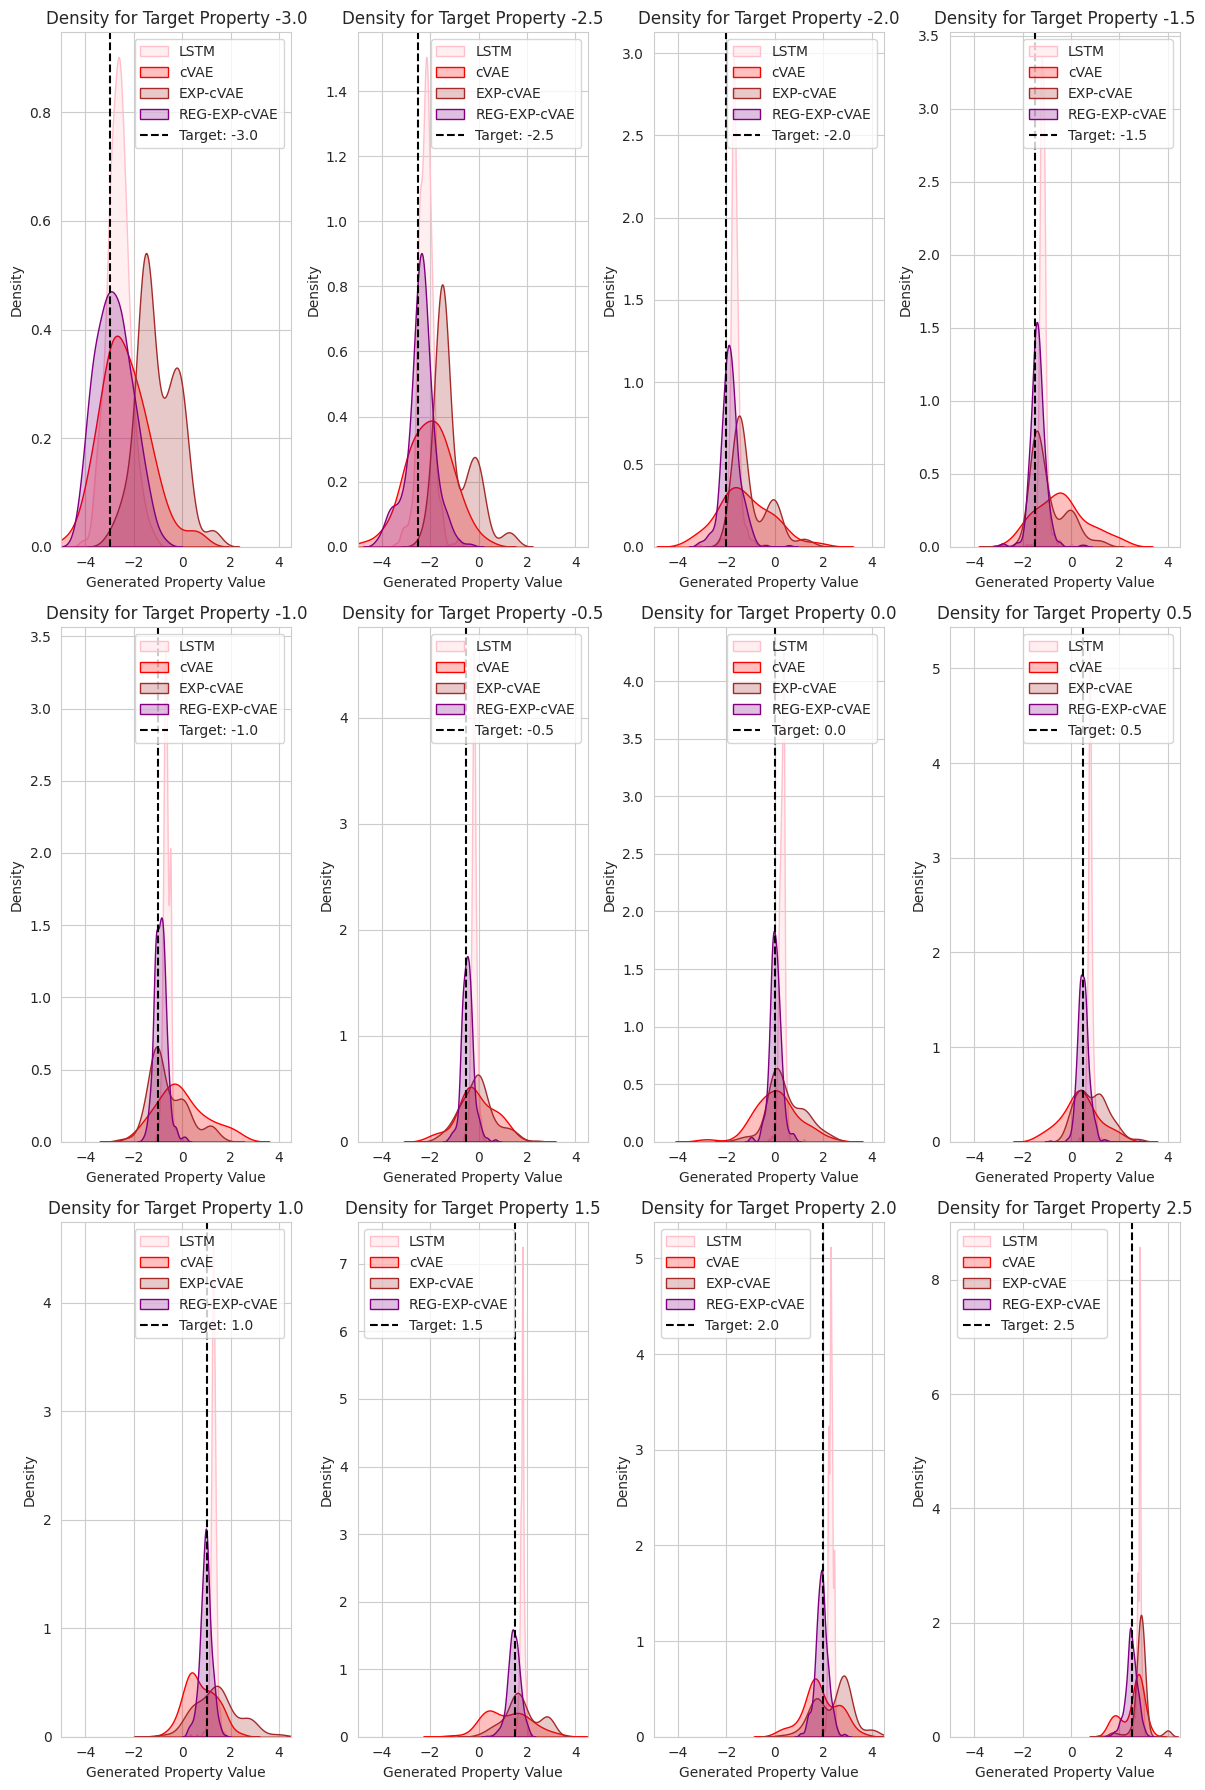

In [131]:
# Example properties range and sampling setup
property_steps = np.arange(-3, 3, 0.5)

# Set up the figure and axes
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(12, 18))  # 6 plots in a 3x2 grid
axs = axs.flatten()  # Flatten to make indexing easier

# Colors for each model for consistent visualization
colors = {
    'LSTM': 'pink',
    'cVAE': 'red',
    'EXP-cVAE': 'brown',
    'REG-EXP-cVAE': 'purple'
}

# Iterate over each property step and its corresponding axis
for i, (p_val, ax) in enumerate(zip(property_steps, axs)):
    # Plot density for each model
    for model, color in colors.items():
        sns.kdeplot(model_steps_properties[model][i], ax=ax, label=model, color=color, fill=True)
    
    # Add a vertical line for the target property
    ax.axvline(x=p_val, color='black', linestyle='--', linewidth=1.5, label='Target: {:.1f}'.format(p_val))
    
    # Set titles and labels
    ax.set_title(f'Density for Target Property {p_val:.1f}')
    ax.set_xlabel('Generated Property Value')
    ax.set_ylabel('Density')
    ax.set_xlim(property_steps[0] - 2, property_steps[-1] + 2)
    ax.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()